In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn import preprocessing
from sklearn.model_selection import *
from models import *

## **Exploratory Data Analysis**

In [2]:
data = pickle.load(open(r'../Data/deltaQ_cycles_v3.pkl', 'rb'))
#data2 = pickle.load(open(r'../Data/temp_features.pkl', 'rb'))

print(data['b1c1'].keys())

dict_keys(['cycle_life', 'DeltaQ_logVars', 'DeltaQ_mins', 'DeltaQ_means', 'DeltaT_max', 'DeltaT_logVars', 'DeltaIR'])


In [3]:
n_cycles = 98
cut_start = 1

features = [
    "DeltaQ_logVars",
    # "DeltaQ_mins",
    # "DeltaQ_means",
    "DeltaT_max",
    # "DeltaT_var",
]

n_cycles = n_cycles - cut_start
y = np.zeros(124)
x = np.zeros((124, n_cycles*len(features)))

for i, cell in enumerate(data.keys()):
    for j, feature in enumerate(features):
        x[i, j*n_cycles:(j+1)*n_cycles] = data[cell][feature][cut_start:]
    y[i] = np.log10(data[cell]["cycle_life"])

# convert to tensors and concatenate features and labels
x = torch.Tensor(x)
y = torch.Tensor(y)

## **AutoEncoder: Dimensionality Reduction**

### **Train Test Split**

In [4]:
test_ind = np.array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
       34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
       68, 70, 72, 74, 76, 78, 80, 82, 83])

train_ind = np.array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67,
       69, 71, 73, 75, 77, 79, 81])

secondary_ind = np.array([ 84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        97,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122,
       123])



Stage 1:

Epoch 3/30, loss: 555301.50
Epoch 6/30, loss: 551623.19
Epoch 9/30, loss: 542687.25
Epoch 12/30, loss: 520001.97
Epoch 15/30, loss: 461880.81
Epoch 18/30, loss: 306525.12
Epoch 21/30, loss: 46302.68
Epoch 24/30, loss: 80288.89
Epoch 27/30, loss: 61590.20
Epoch 30/30, loss: 83470.81
train 	 266.6622
test 	 309.21948
sec 	 520.16974


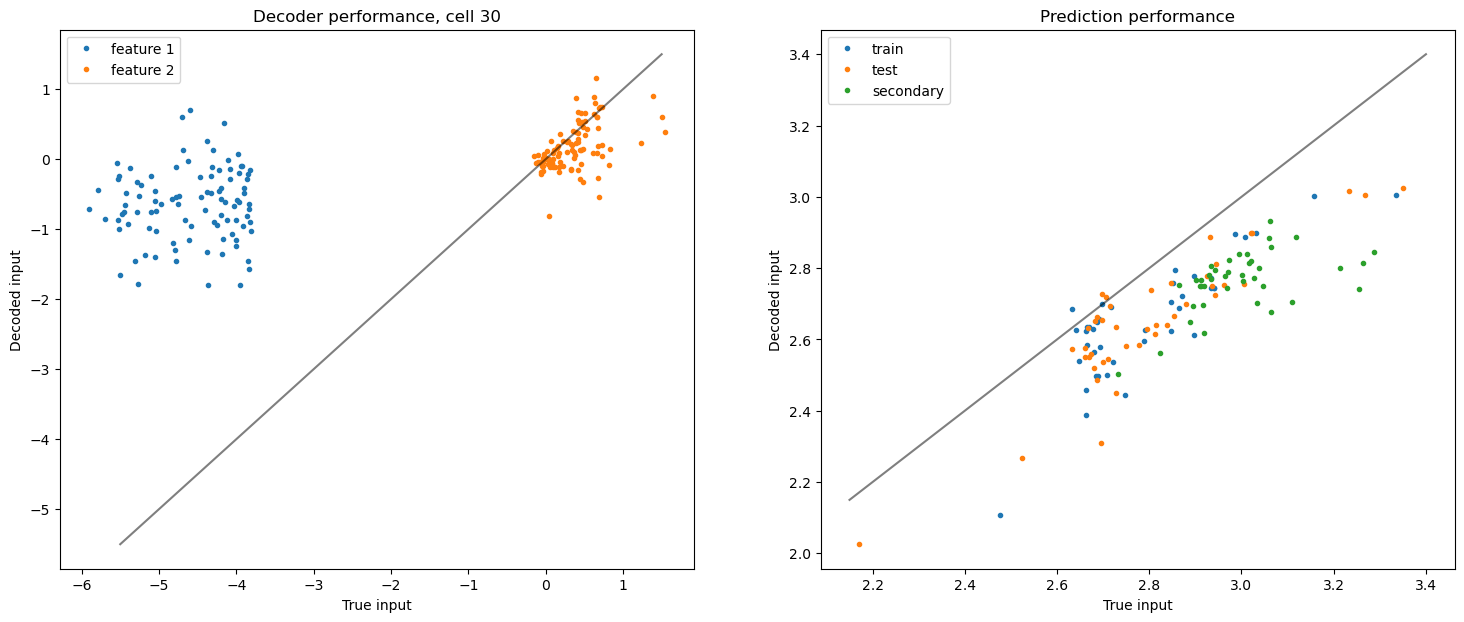


Stage 2:

Epoch 4/40, loss: 11.03
Epoch 8/40, loss: 10.84
Epoch 12/40, loss: 10.18
Epoch 16/40, loss: 9.34
Epoch 20/40, loss: 8.23
Epoch 24/40, loss: 7.37
Epoch 28/40, loss: 6.65
Epoch 32/40, loss: 5.99
Epoch 36/40, loss: 5.35
Epoch 40/40, loss: 4.71
train 	 106.66402
test 	 112.44774
sec 	 316.6771


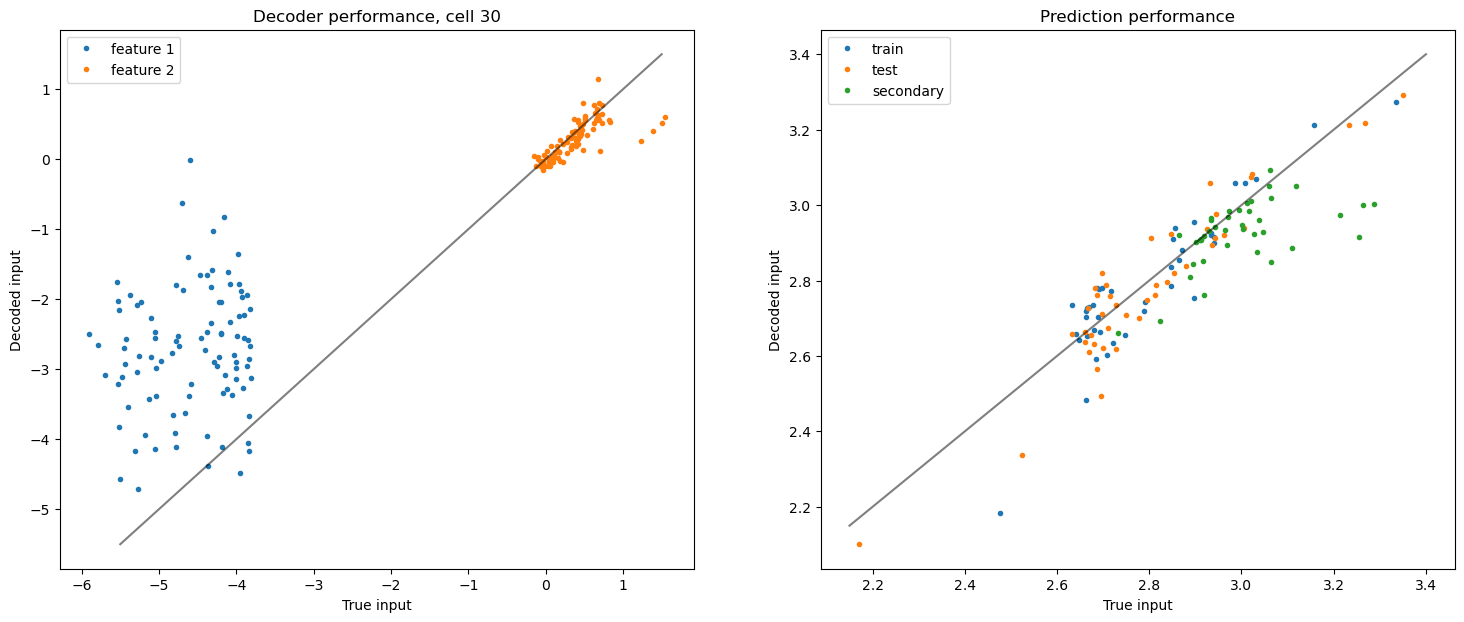


Stage 3:

Epoch 6/60, loss: 11220.57
Epoch 12/60, loss: 11837.35
Epoch 18/60, loss: 14698.09
Epoch 24/60, loss: 11074.76
Epoch 30/60, loss: 8156.53
Epoch 36/60, loss: 7761.46
Epoch 42/60, loss: 7571.89
Epoch 48/60, loss: 6730.45
Epoch 54/60, loss: 6575.63
Epoch 60/60, loss: 6249.47
train 	 78.71461
test 	 110.69436
sec 	 326.07233


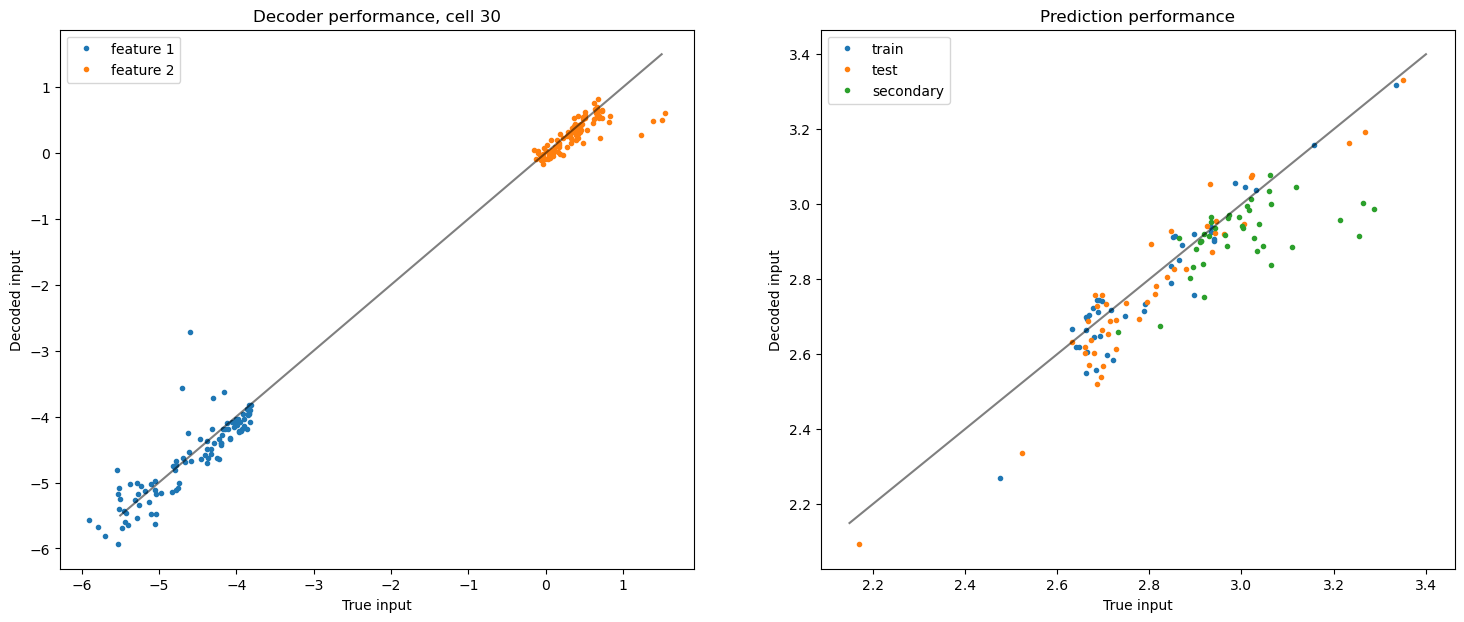

In [5]:
train_policy = {
    "num_stages": 3,
    "epochs": [30, 40, 60],
    "learning_rates": [5e-4, 5e-4, 5e-4],
    "batch_sizes": [64, 64, 64],
    "prediction_weights": [1, 0.0001, 1],
    "decoding_weights": [10, 1, 0.0001],
    "en_weights": [1, 1, 1]
}


model = AutoEncoder_ElasticNet(n_features=len(features), n_cycles=n_cycles)
#train = TensorDataset(torch.Tensor(x[train_ind]),torch.Tensor(y[train_ind]))
model.fit(x,y, train_policy)

In [6]:
model.encoder(x[5])

tensor([0.0000, 0.0000, 0.0000, 1.9047, 1.0634, 0.6122, 0.0000, 0.0000, 0.4524,
        0.2975, 4.0509, 0.0000, 1.6004, 6.4573, 0.0000, 0.0000, 5.9602, 0.0000,
        0.0000, 0.0000, 2.6287, 1.7684, 2.9844, 3.0317, 0.5513, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.4387], grad_fn=<ReluBackward0>)

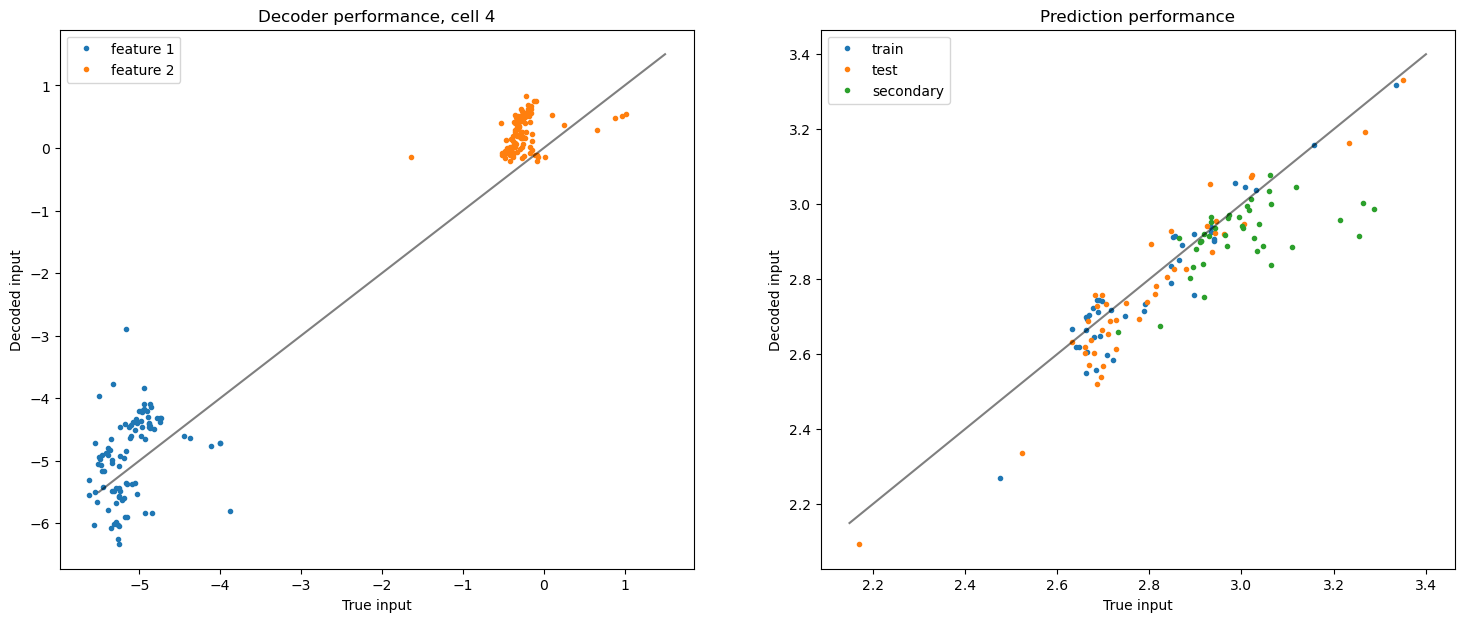

In [7]:
model.plotter(x, y, 4)

In [8]:
print(y[1], model.elastic_net_predict(x[1]))

tensor(3.3345) tensor([3.3177], grad_fn=<AddBackward0>)


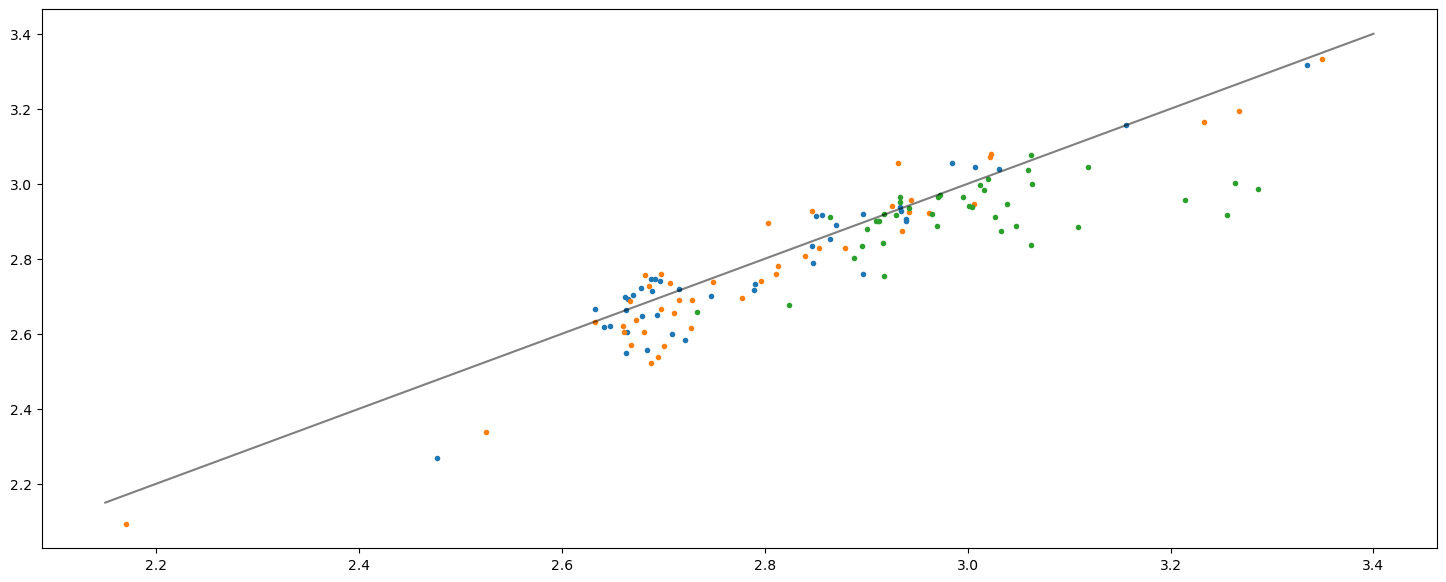

In [9]:
plt.plot(y[train_ind], model.elastic_net_predict(x[train_ind]).detach().numpy(), ".")
plt.plot(y[test_ind], model.elastic_net_predict(x[test_ind]).detach().numpy(), ".")
plt.plot(y[secondary_ind], model.elastic_net_predict(x[secondary_ind]).detach().numpy(), ".")
plt.plot(np.linspace(2.15, 3.4, 3), np.linspace(2.15, 3.4, 3), "k", alpha = 0.5)

# SVR

In [10]:
x_t = model.encoder(x[train_ind]).detach().numpy()
x_te = model.encoder(x[test_ind]).detach().numpy()
x_ste = model.encoder(x[secondary_ind]).detach().numpy()

print(x_t[0])

[0.         0.         0.         1.968496   1.1975303  0.6349559
 0.         0.         0.4784743  0.2291374  4.420183   0.
 1.8289057  6.948738   0.         0.         6.382587   0.
 0.         0.         2.7779877  2.0144775  3.3619432  3.371449
 0.5259101  0.         0.         0.         0.         0.
 0.         0.38798362]


In [11]:
scaler = preprocessing.StandardScaler().fit(list(x_t))
x_t = scaler.transform(list(x_t))
x_te = scaler.transform(list(x_te))
x_ste = scaler.transform(list(x_ste))

train = TensorDataset(torch.Tensor(x_t),torch.Tensor(y[train_ind]))
test = TensorDataset(torch.Tensor(x_te),torch.Tensor(y[test_ind]))
stest = TensorDataset(torch.Tensor(x_ste),torch.Tensor(y[secondary_ind]))

In [12]:
# parameters
lr = 0.001
feat_dim = 2*16
d_model = 12
nepoch = 3000
batch_size = 1

In [13]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [14]:
# Load nodel, loss function, and optimizer
model = AttentionModel(feat_dim=feat_dim,d_model=d_model)
criterion = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)


model.train()

# Training loop
for i in range(nepoch):
    total_loss_train = 0.0
    total_loss_test = 0.0
    total_loss_stest = 0.0

    train_batched = DataLoader(train,batch_size=batch_size,shuffle=True)
    test_batched = DataLoader(test,batch_size=1)
    stest_batched = DataLoader(stest,batch_size=1)

    for j,batch in enumerate(train_batched):
        optimizer.zero_grad()
        train_input, train_label = batch
        output = model(train_input.to(device))
        loss = criterion(10**output, 10**train_label)
        total_loss_train += loss.item()

        loss.backward()
        optimizer.step()

    for cell in test_batched:
        test_input, test_label = cell
        test_output = model(test_input.to(device))
        test_loss = criterion(10**test_output, 10**test_label)

        total_loss_test += test_loss.item()

    for cell in stest_batched:
        stest_input, stest_label = cell
        stest_output = model(stest_input.to(device))
        stest_loss = criterion(10**stest_output, 10**stest_label)
        

        # print(i, output, train_label, loss)
        total_loss_stest += stest_loss.item()

    rmse_train = np.sqrt(total_loss_train / (j+1))
    rmse_test = np.sqrt(total_loss_test / len(test))
    rmse_stest = np.sqrt(total_loss_stest / len(stest))
    #wandb.log({"Epoch": i+1, "RMSE_train": rmse_train, "RMSE_test": rmse_test, "RMSE_stest": rmse_stest})
    if (i+1)%50 == 0: 
        print(f'Epochs: {i + 1} | rmse: {rmse_train: .3f} | rmse_test: {rmse_test: .3f} | rmse_stest: {rmse_stest: .3f}')

#wandb.finish()

/Users/nathansun/opt/anaconda3/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epochs: 50 | rmse:  622.387 | rmse_test:  746.698 | rmse_stest:  1040.057
Epochs: 100 | rmse:  637.953 | rmse_test:  749.377 | rmse_stest:  1037.832
Epochs: 150 | rmse:  606.040 | rmse_test:  781.000 | rmse_stest:  1036.294
Epochs: 200 | rmse:  595.595 | rmse_test:  854.760 | rmse_stest:  1030.410
Epochs: 250 | rmse:  585.313 | rmse_test:  863.638 | rmse_stest:  1018.883
Epochs: 300 | rmse:  578.700 | rmse_test:  738.062 | rmse_stest:  1000.912
Epochs: 350 | rmse:  537.371 | rmse_test:  809.768 | rmse_stest:  974.007
Epochs: 400 | rmse:  501.993 | rmse_test:  722.249 | rmse_stest:  914.427
Epochs: 450 | rmse:  473.732 | rmse_test:  709.000 | rmse_stest:  858.091
Epochs: 500 | rmse:  438.673 | rmse_test:  660.902 | rmse_stest:  801.228
Epochs: 550 | rmse:  399.991 | rmse_test:  561.055 | rmse_stest:  715.204
Epochs: 600 | rmse:  348.933 | rmse_test:  486.070 | rmse_stest:  593.118
Epochs: 650 | rmse:  270.289 | rmse_test:  336.630 | rmse_stest:  476.717
Epochs: 700 | rmse:  194.181 | rm

In [15]:
plt.style.use("seaborn-v0_8")
from matplotlib.patches import Patch

61.29839518526466
113.23519426896075
323.9897725729579


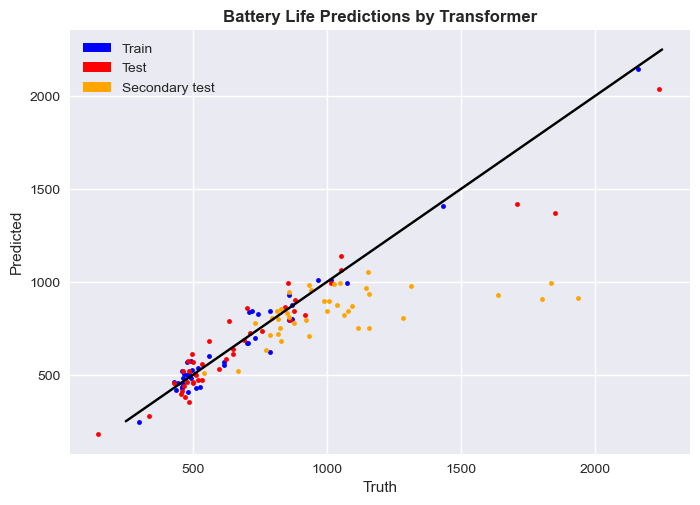

In [16]:
fig,ax = plt.subplots()
colors = ["blue","red","orange"]
for i,dataset in enumerate([train,test,stest]):
    predicted =[]
    labels = []
    for cell in dataset:
        input, label = cell
        predicted.append(10**model(input[None,:].to(device)).detach().numpy()[0,0])
        labels.append(10**label)
    print(np.sqrt(np.mean(np.power(np.array(predicted)-np.array(labels),2))))

    ax.plot(labels, predicted, ".",color=colors[i])
    ax.set_xlabel("Truth")
    ax.set_ylabel("Predicted")

ax.plot(np.linspace(250,2250),np.linspace(250,2250),color="black")
ax.set_title("Battery Life Predictions by Transformer",fontweight="semibold")

legend_elements = [Patch(facecolor='blue', label='Train'),
                   Patch(facecolor='red', label='Test'),
                   Patch(facecolor='orange', label='Secondary test')]
ax.legend(handles=legend_elements)
#plt.savefig("../images/transformer_output.png",dpi=300)